<a href="https://colab.research.google.com/github/Bnibling/Thinkful_Data_Science_Immersion_Portfolio/blob/main/Big_Data_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this challenge, you'll replicate one of the supervised learning projects that you did before in the program. This time, you'll use Dask instead of pandas and NumPy. Follow the instructions below:

1. The aim of this challenge is to get your hands dirty on writing code using Dask. This is why there is no minimum or maximum limit on the size of the dataset that you can use.

2. Use Dask counterparts to replicate all the data-cleaning and machine-learning parts of your supervised learning project. In other words, do the following:

>* Instead of pandas DataFrames, use Dask DataFrames whenever possible.

>* Instead of NumPy arrays, use Dask arrays whenever possible.

>* Use Dask to parallelize your model trainings.

Decided to use dask to build a gradient boost model on the European Social Survey data to determine whether or not comeone lives with a partner.

In [79]:
!pip install dask[dataframe] --upgrade --quiet
!pip install dask-ml --quiet
!pip install aiohttp --quiet
!python -m pip install "dask[distributed]" --upgrade

Requirement already up-to-date: dask[distributed] in /usr/local/lib/python3.6/dist-packages (2021.1.0)


In [126]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import joblib
from dask.distributed import Client, progress
from dask_ml.model_selection import train_test_split
import dask.dataframe as dd
import dask.array as da
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, plot_confusion_matrix

In [81]:
client = Client(n_workers=4, threads_per_worker=2, memory_limit='2GB')
client

/usr/local/lib/python3.6/dist-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33409 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:33831 Dashboard: http://127.0.0.1:33409/status,Cluster Workers: 4 Cores: 8 Memory: 8.00 GB


In [82]:
df = dd.read_csv("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")

In [83]:
df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


In [84]:
df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 13 entries, cntry to partner
dtypes: object(1), float64(11), int64(1)

In [85]:
df.shape[0].compute()

8594

#1. Cleaning

In [86]:
df.isnull().sum().compute().sort_values(ascending=False)

agea       239
sclact      94
pplfair     39
happy       31
pplhlp      25
partner     17
sclmeet     15
ppltrst     14
gndr        10
tvtot        8
year         0
idno         0
cntry        0
dtype: int64

In [87]:
df = df.dropna()

In [88]:
df.isnull().sum().compute().sort_values(ascending=False)

partner    0
agea       0
gndr       0
sclact     0
sclmeet    0
happy      0
pplhlp     0
pplfair    0
ppltrst    0
tvtot      0
year       0
idno       0
cntry      0
dtype: int64

In [89]:
df['partner'].value_counts().compute()

1.0    5013
2.0    3134
Name: partner, dtype: int64

In [90]:
df['partner'] = df['partner'].mask(df['partner'] == 2.0, 1).mask(df['partner'] == 1.0, 0).astype('int')

In [91]:
df['partner'].value_counts().compute()

0    5013
1    3134
Name: partner, dtype: int64

In [93]:
df['cntry'] = df['cntry'].astype('category')

In [94]:
df = dd.concat([df, dd.get_dummies(df['cntry'].cat.as_known())], axis=1)

/usr/local/lib/python3.6/dist-packages/dask/dataframe/multi.py:1133: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are 
 aligned. This assumption is not generally safe.
  "Concatenating dataframes with unknown divisions.\n"


In [95]:
df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner,CH,CZ,DE,ES,NO,SE
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,0,1,0,0,0,0,0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,0,1,0,0,0,0,0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,1,1,0,0,0,0,0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,0,1,0,0,0,0,0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,0,1,0,0,0,0,0


#2. Modeling

In [97]:
X = df.drop(['partner', 'cntry', 'idno'], 1)
y = df['partner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [98]:
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

gbc = GradientBoostingClassifier(**params)

with joblib.parallel_backend('dask'):
  gbc.fit(X_train.compute(), y_train.compute())

y_pred_train = gbc.predict(X_train.values.compute())
y_pred_test = gbc.predict(X_test.values.compute())

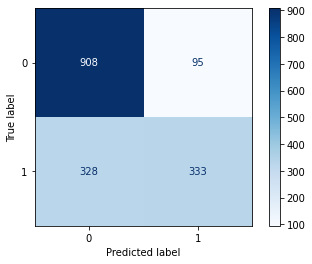

In [104]:
plot_confusion_matrix(gbc, X_test.compute(), y_test.compute(), values_format='.0f', cmap='Blues')
plt.show()

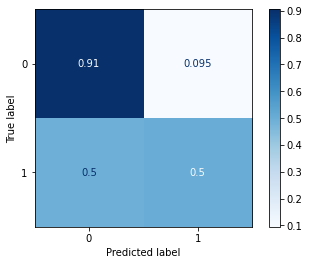

In [107]:
plot_confusion_matrix(gbc, X_test.compute(), y_test.compute(), cmap='Blues', normalize='true')
plt.show()

In [123]:
gbc_score = gbc.score(X_test.compute(), y_test.compute())
gbc_precision = precision_score(y_test.compute(), y_pred_test)
gbc_recall = recall_score(y_test.compute(), y_pred_test)

print(f'Gradient boosting test score is: {gbc_score}')
print(f'Gradient boosting test precision score is: {gbc_precision}')
print(f'Gradient boosting test recall score is: {gbc_recall}')

Gradient boosting test score is: 0.7457932692307693
Gradient boosting test precision score is: 0.7780373831775701
Gradient boosting test recall score is: 0.5037821482602118


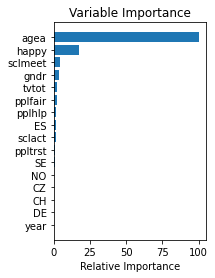

In [135]:
import numpy as np #there is no argsort for dask.array

feature_importance = gbc.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = da.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos.compute(), feature_importance[sorted_idx], align='center')
plt.yticks(pos.compute(), X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()